In [12]:
debugging = True

# Description 

# Python Import

In [33]:
from __code.__all import custom_style
custom_style.style()

import matplotlib.patches as patches
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os

In [13]:
from __code.normalization import utilities, gui_widgets, file_handler, fileselector

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.core.display import display, HTML

if debugging:
    ipts = 17099
else:
    ipts = utilities.get_ipts()
working_dir = utilities.get_working_dir(ipts=ipts)

# Select Sample Images 

In [15]:
list_images_ui = fileselector.FileSelectorPanel(instruction='Select samples images', start_dir=working_dir, multiple=True)
list_images_ui.show()

# Select OB 

In [16]:
list_ob_ui = fileselector.FileSelectorPanel(instruction='Select OB images', start_dir=working_dir, multiple=True)
list_ob_ui.show()

# Loding data 

In [17]:
list_images = list_images_ui.result_full_path()
list_obs = list_ob_ui.result_full_path()

box1 = widgets.HBox([widgets.Label("Loading Sample Progress:",
                                      layout=widgets.Layout(width='20%')),
                        widgets.IntProgress(max=len(list_images))])
display(box1)
w1 = box1.children[1]
    
box2 = widgets.HBox([widgets.Label("Loading OB Progress:",
                                      layout=widgets.Layout(width='20%')),
                        widgets.IntProgress(max=len(list_obs))])
display(box2)
w2 = box2.children[1] 

sample_array = []
for _index1, _file in enumerate(list_images):
    _data = file_handler.load_data(_file)
    sample_array.append(_data)
    w1.value = _index1 + 1

ob_array = []
for _index2, _file in enumerate(list_obs):
    _data = file_handler.load_data(_file)
    ob_array.append(_data)
    w2.value = _index2 + 1

    

# Preview Data

<IPython.core.display.Javascript object>


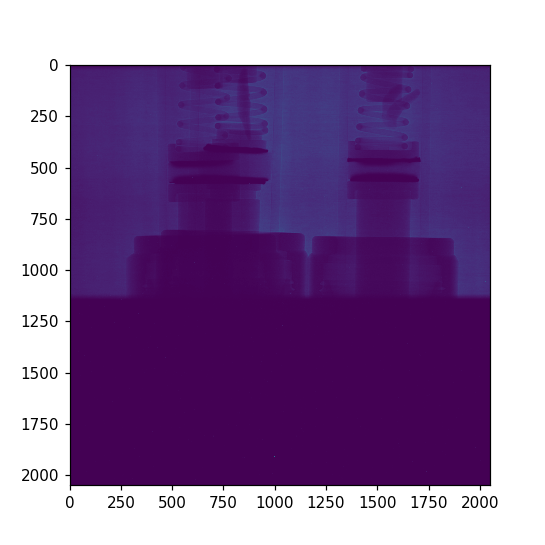

In [23]:
def plot_images(index):
    fig = plt.figure(figsize=(5,5))
    ax_img = plt.subplot(111)
    ax_img.imshow(sample_array[index], cmap='viridis')
    
preview = interact(plot_images,
                  index = widgets.IntSlider(min=0, 
                                             max=len(list_images)-1,
                                                step=1,
                                                value=0,
                                                description='Image Index',
                                           continuous_update=False))

<IPython.core.display.Javascript object>


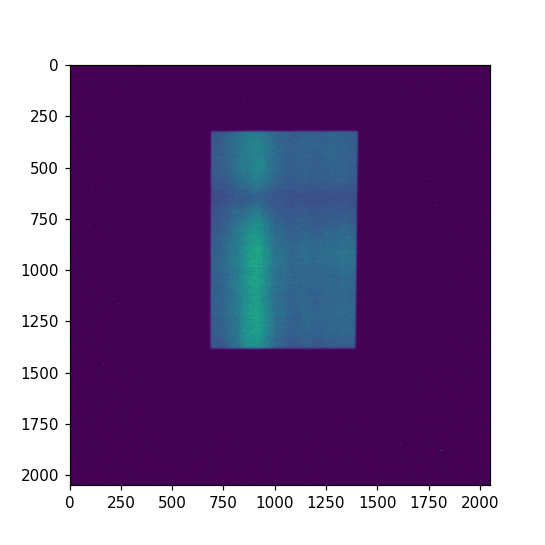

In [25]:
def plot_obs(index):
    fig = plt.figure(figsize=(5,5))
    ax_img = plt.subplot(111)
    ax_img.imshow(ob_array[index], cmap='viridis')
    
preview = interact(plot_obs,
                  index = widgets.IntSlider(min=0, 
                                             max=len(list_obs)-1,
                                                step=1,
                                                value=0,
                                                description='Image Index',
                                           continuous_update=False))

# Select Background Region 

<IPython.core.display.Javascript object>


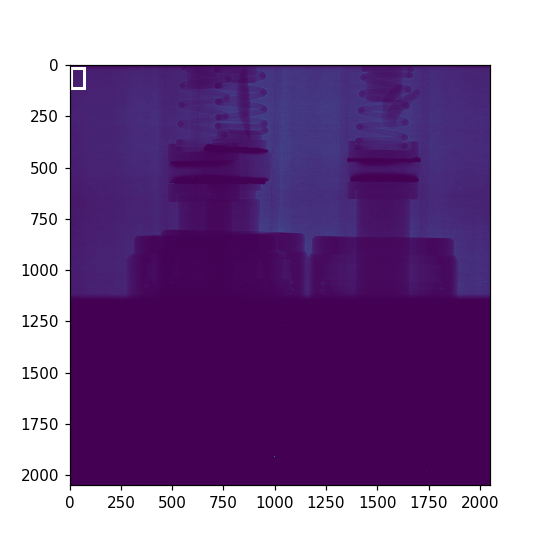

[8, 13, 60, 100]

In [28]:
[height, width] = np.shape(sample_array[0])

def plot_roi(image_index, x_left, y_top, width, height):
    
    fig = plt.figure(figsize=(5,5))
    ax_img = plt.subplot(111)
    ax_img.imshow(sample_array[image_index],
                 cmap='viridis')
    
    _rectangle = patches.Rectangle((x_left, y_top),
                                  width,
                                  height,
                                  edgecolor = 'white',
                                  linewidth = 2,
                                  fill = False)
    ax_img.add_patch(_rectangle)
    
    return [x_left, y_top, width, height]
    
preview_bragg_edge = interact(plot_roi,
                image_index = widgets.IntSlider(min=0,
                                               max=len(list_images)-1,
                                               value=0,
                                               description='Image index:',
                                               continuous_update=False), 
                  x_left = widgets.IntSlider(min=0,
                                            max=width,
                                            step=1,
                                            value=8,
                                            description='X Left',
                                            continuous_update=False),
                  y_top = widgets.IntSlider(min=0,
                                           max=height,
                                           value=13,
                                           step=1,
                                           description='Y Top',
                                           continuous_update=False),
                  width = widgets.IntSlider(min=0,
                                           max=width,
                                           step=1,
                                           value=60,
                                           description="Width",
                                           continuous_update=False),
                  height = widgets.IntSlider(min=0,
                                            max=height,
                                            step=1,
                                            value=100,
                                            description='Height',
                                            continuous_update=False))

# Normalization

In [29]:
[x_left, y_top, width_roi, height_roi] = preview_bragg_edge.widget.result

ob_mean = np.array(ob_array).mean(axis=0)
ob_cropped = ob_mean[y_top:y_top+height, x_left:x_left+width]
ob_cropped_mean = ob_cropped.mean()

#import images
w = widgets.IntProgress()
w.max = len(list_images)
display(w)

_index = 0
#normalized_data_array = []
#final_list_of_temperature_for_each_bin = []

normalized_data_array = []
for _index, _data in enumerate(sample_array):
    
    data_cropped = _data[y_top:y_top+height_roi, x_left:x_left+width_roi]
    coeff = data_cropped.mean() / ob_cropped_mean

    _normalized = _data / ob_mean
    _normalized /= coeff
    
    normalized_data_array.append(_normalized)
    
    w.value = _index+1

# Export 

In [31]:
output_folder_ui = fileselector.FileSelectorPanel(instruction='Select Output Folder', start_dir=working_dir, multiple=False, type='directory')
output_folder_ui.show()

In [34]:
output_folder = os.path.join(output_folder_ui.curdir, output_folder_ui.result(), 'normalization')
utilities.make_dir(dir=output_folder)

w = widgets.IntProgress()
w.max = len(list_images)
display(w)

for _index, _file in enumerate(list_images):
    basename = os.path.basename(_file)
    output_file_name = os.path.join(output_folder, basename)
    file_handler.make_tiff(filename=output_file_name, data=normalized_data_array[_index])
    
    w.value = _index+1